<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Andrew/sources/stock_predictor_Image-CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Imports

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#!pip install pandas_ta
#import pandas_ta as ta

# Set Plot Stylizations

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('dark_background')

# Method for getting ticker data using Yahoo Finance API

This method downloads json data from the Yahoo! finance API and organizes it into a Pandas dataframe. The time frame of the data can start and end wherever the user wants it to. The start and end dates need to be a String in the form of a Unix Timestamp.

*Parameters:*

    ticker: String that specifies the trading ticker of the equity 
    startData: String that specifies the start time of the dataset. Formatted as a Unix Timestamp
    endData: String that specifies the start time of the dataset. Formatted as a Unix Timestamp

*Returns:*

    df: Pandas dataframe with timestamp, open, high, low, close, and volume of a ticker


*Resources:*
*   [Dataframe.shift](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html)



In [3]:
def getStockDataInRange(ticker: str, startDate: str, endDate: str):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?period1=" + startDate + "&period2=" + endDate + "&useYfid=true&interval=1d&includePrePost=true&events=div%7Csplit%7Cearn&lang=en-US&region=US&crumb=Yo9B6QaqJUD&corsDomain=finance.yahoo.com"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    # Difference if based on 'close' price
    df['diff'] = df['close'].diff()
    df['diff'] = df['diff'].fillna(0)
    df['change'] = df['diff'] / df['close'].shift(periods=1) * 100
    df['change'] = df['change'].fillna(0)
    return df

def toDatetime(t):
    return datetime.fromtimestamp(t)

# Creating Dataframe with stock data

In [4]:
ticker = 'QQQ'
endDate = datetime(year=2020, month=12, day=31, hour=0, minute=0).strftime('%s')
startDate = datetime(year=2009, month=1, day=1, hour=0, minute=0).strftime('%s')

df = getStockDataInRange(ticker=ticker, startDate=startDate, endDate=endDate)

# Function for plotting stock prices of data frame

In [21]:
def visualize_prices(df, x_values, y_values, title=ticker + ' prices in set range', figsize=(12,8)):
    ax = df.plot(x=x_values, y=[y_values], kind='line', title=title, figsize=figsize)
    vals = ax.get_yticks()
    ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    plt.show()

# Function for plotting Indicators

In [6]:
def plot_indicators(df, columns, yTitle, xTitle):
    plt.figure()
    ax = df[columns].plot(title=yTitle)
    ax.set_xlabel(xTitle)
    ax.set_ylabel(yTitle)

# Function for visualization for Trading Markers (Buy/Sell)

In [22]:
def visualize_trading_markers(df, title, markers, x='timestamps', y=['close'], color='red', figsize=(12,8)):
    ax = df.plot(
        x=x, 
        y=y, 
        kind='line', 
        color=color, 
        title=title, 
        markevery=markers, 
        marker='o', 
        markerfacecolor='white',
        figsize=figsize)
    vals = ax.get_yticks()
    ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    plt.show()

# Plotting QQQ open prices from January 1, 2010 to December 31st, 2020

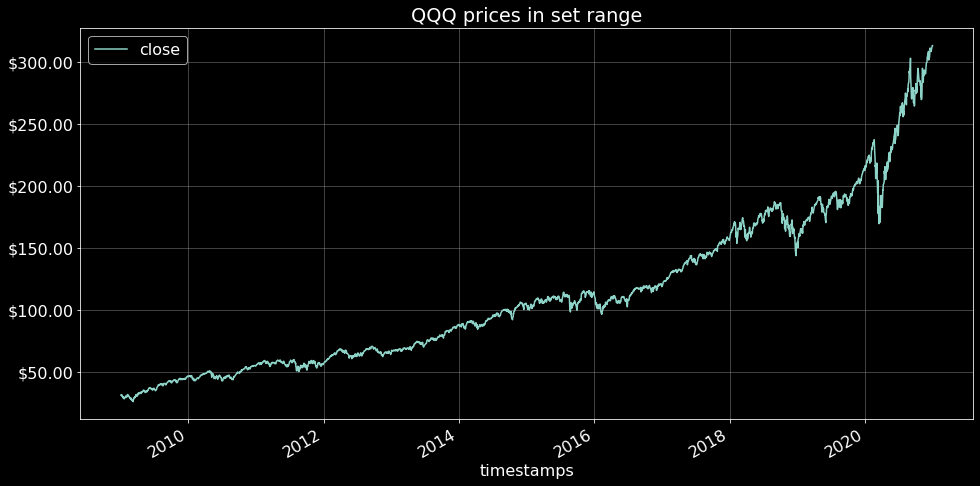

In [24]:
visualize_prices(df, 'timestamps', 'close', figsize=(16, 8))

# Method for labeling price data as BUY, HOLD, or SELL

In [12]:
from tqdm.auto import tqdm

def create_labels(df, col_name, window_size=11):

    row_counter = 0
    total_rows = len(df)
    # Creates a 1 x N numpy array
    labels = np.zeros(total_rows)
    # Makes all the entries in labels array equal to nan
    labels[:] = np.nan
    # Sets up a progress bar
    pbar = tqdm(total=total_rows)

    while row_counter < total_rows:

        # Stalls labeling calculation until the row_counter is at least as big as the window_size
        if row_counter >= window_size - 1:
            window_begin = row_counter - (window_size - 1)
            window_end = row_counter
            window_middle = (window_begin + window_end) // 2 # Cast as int

            min_ = np.inf
            min_index = -1
            max_ = -np.inf
            max_index = -1
            for i in range(window_begin, window_end + 1):
                # Selected value at 'i' index in column with name equal to col_name variable
                price = df.iloc[i][col_name]
                if price < min_:
                    # Finds the smallest value in the window
                    # 'min_' is initially set to infinity
                    min_ = price
                    # Saves the index of the lowest value
                    min_index = i
                if price > max_:
                    # Finds the largest value in the window
                    # 'max_' is initially set to -infinity
                    max_ = price
                    # Saves the index of the largest value
                    max_index = i

            if max_index == window_middle:
                # Sets label to SELL
                labels[window_middle] = 0
            elif min_index == window_middle:
                # Sets label to BUY
                labels[window_middle] = 1
            else:
                # Sets label to HOLD
                labels[window_middle] = 2

        row_counter = row_counter + 1
        pbar.update(1)

    pbar.close()
    return labels

# Plotting of prediction labels using 'close' column to visualize distribution across time frame

Text(0.5, 1.0, 'Prediction Labels')

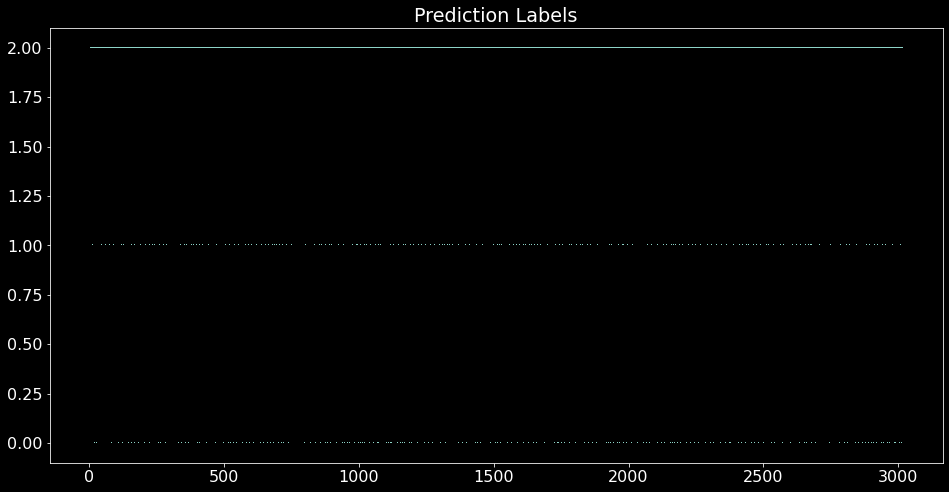

In [13]:
labels = create_labels(df, 'close')
df['labels'] = labels
df['labels'] = df['labels'].fillna(0)

fig = plt.figure()
plt.plot(labels, ',')
plt.title('Prediction Labels')

# Visualization of location of BUY markers for QQQ

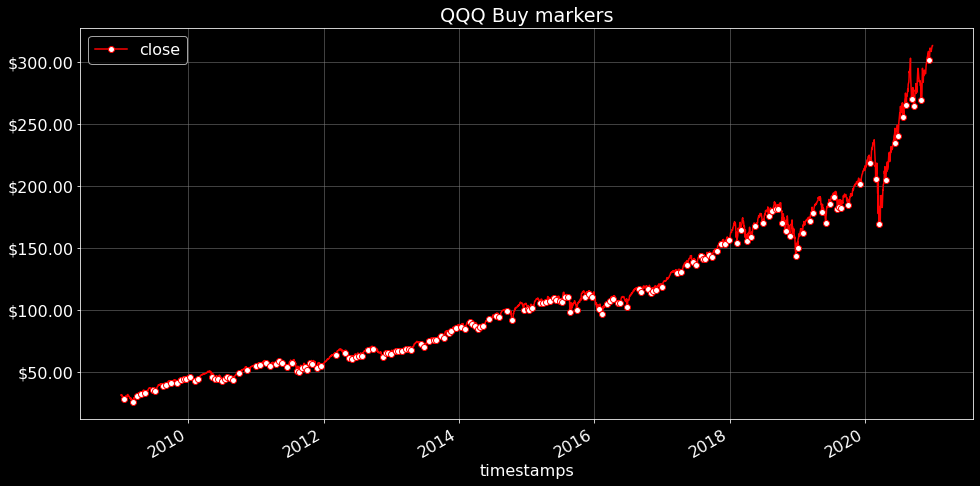

In [16]:
buy_markers = list(np.where(df['labels'] == 1)[0])
visualize_trading_markers(df, title=ticker + ' Buy markers', markers=buy_markers)

# Visualization of location of SELL markers for QQQ

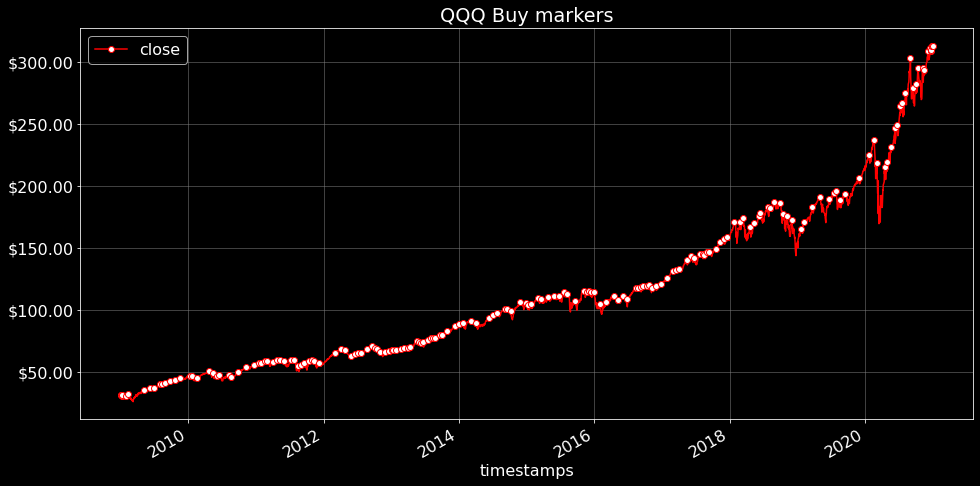

In [17]:
sell_markers = list(np.where(df['labels'] == 0)[0])
visualize_trading_markers(df, title=ticker + ' Buy markers', markers=sell_markers)

# Showing Dataframe head

In [ ]:
df.head()

,timestamps,open,high,low,close,volume,diff,change,labels
0,2009-01-02 14:30:00,29.750000,31.129999,29.690001,31.030001,107891500,0.000000,0.000000,0.0
1,2009-01-05 14:30:00,30.830000,31.330000,30.590000,31.020000,91751900,-0.010000,-0.032228,0.0
2,2009-01-06 14:30:00,31.250000,31.629999,31.110001,31.330000,136791700,0.309999,0.999354,0.0
3,2009-01-07 14:30:00,30.730000,30.900000,30.190001,30.440001,133879800,-0.889999,-2.840726,0.0
4,2009-01-08 14:30:00,30.379999,30.799999,30.080000,30.760000,131926600,0.320000,1.051247,0.0


# Creating Training Data

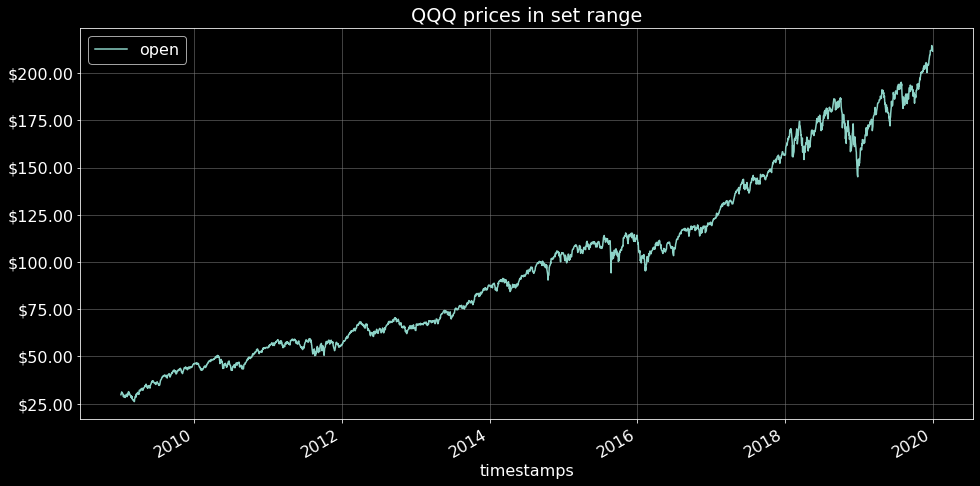

In [ ]:
training_data = df[df['timestamps']<'2020-01-01'].copy()
visualize_prices(training_data, 'timestamps', 'open')

training_data = training_data.drop(['timestamps'], axis=1)
training_data = training_data.iloc[1:]    # Drops first row in dataframe
training_copy = training_data   # Need this to append last n row to testing data later
print(training_data)
#training_data.head() 

In [ ]:
# from pandas_ta import ppo,hma,psar,cmo,tema,cmf,trix, kst,macd,roc,ema,dema,cci,rsi,willr,stoch,mfi,bbands
# import pandas_ta  as ta

            open        high         low  ...      diff    change  labels
1      30.830000   31.330000   30.590000  ... -0.010000 -0.032228     0.0
2      31.250000   31.629999   31.110001  ...  0.309999  0.999354     0.0
3      30.730000   30.900000   30.190001  ... -0.889999 -2.840726     0.0
4      30.379999   30.799999   30.080000  ...  0.320000  1.051247     0.0
5      30.770000   30.790001   29.920000  ... -0.690001 -2.243175     2.0
...          ...         ...         ...  ...       ...       ...     ...
2763  212.000000  212.089996  211.440002  ...  0.110001  0.051934     2.0
2764  212.259995  213.809998  212.229996  ...  1.869995  0.882406     2.0
2765  214.539993  214.559998  213.039993  ... -0.179993 -0.084191     2.0
2766  213.500000  213.630005  211.160004  ... -1.399994 -0.655397     2.0
2767  211.529999  212.759995  211.199997  ...  0.399994  0.188490     2.0

[2767 rows x 8 columns]


In [ ]:
  # dftemp = pd.DataFrame
  # dftemp = bbands(df['close']).fillna(0)
  # print(dftemp)

In [ ]:

######################################## Trend Indicators ############################

# # MACD: Moving Average Convergance Diverage Momentum
# def calculate_macd(df, iteration):
#     dftemp = pd.DataFrame
#     dftemp = macd(df['close']).fillna(0)
#     df['MACD_'+str(iteration)] = dftemp['MACD_12_26_9' ]
# # ROC: Price Rate of Change
# def calculate_roc(df, iteration):
#     dftemp = pd.DataFrame
#     dftemp = roc(df['close']).fillna(0)
#     df['ROC_'+str(iteration)] = dftemp
# # EMA: Exponential Moving Average
# def calculate_ema(df, iteration):
#     dftemp = pd.DataFrame
#     dftemp = ema(df['close']).fillna(0)
#     df['EMA_'+str(iteration)] = dftemp

# # DEMA: Double Exponential Moving Average
# def calculate_dema(df, iteration):
#     dftemp = pd.DataFrame
#     dftemp = dema(df['close']).fillna(0)
#     df['DEMA_'+str(iteration)] = dftemp
   
# # CCI: Commodity Channel Index
# def calculate_cci(df, iteration):  
#     dftemp = pd.DataFrame
#     dftemp = cci(df['high'],df['low'],df['close']).fillna(0)
#     df['CCI_'+str(iteration)] = dftemp

# # RSI: Relative Strength Index     
# def calculate_rsi(df, iteration):
#     dftemp = pd.DataFrame
#     dftemp = rsi(df['close']).fillna(0)
#     df['RSI_'+str(iteration)] = dftemp

# # WR: Williams %R Indicator
# def calculate_WR(df, iteration):
#     dftemp = pd.DataFrame
#     dftemp = willr(df['high'],df['low'],df['close']).fillna(0)
#     df['WR_'+str(iteration)] = dftemp

# # SR: Stochastic Oscillator
# def calculate_sr(df, iteration):
#     dftemp = pd.DataFrame
#     dftemp = stoch(df['high'],df['low'],df['close']).fillna(0)
#     df['SR_'+str(iteration)] = dftemp["STOCHd_14_3_3"]

# # MFI: Money Flow Index
# def calculate_mfi(df, iteration):
#     dftemp = pd.DataFrame
#     dftemp = mfi(df['high'],df['low'],df['close'],df['volume']).fillna(0)
#     df['MFI_'+str(iteration)] = dftemp
#  # BB: Bollinger Band look at data frame return  
# def calculate_bb(df, iteration):
#     dftemp = pd.DataFrame
#     dftemp = bbands(df['close']).fillna(0)
#     df['BB_'+str(iteration)] = dftemp['BBB_5_2.0']
# def calculate_cmo(df,iteration):
#     dftemp = pd.DataFrame
#     dftemp = cmo(df['close'])
#     df['CMO_' + str(iteration)] = dftemp.fillna(0)
# def calculate_tema(df,iteration):
#     dftemp = pd.DataFrame
#     dftemp = tema(df['close'])
#     df['TEMA_' + str(iteration)] = dftemp.fillna(0)
# def calculate_cmf(df,iteration):
#     dftemp = pd.DataFrame
#     dftemp = cmf(df['high'],df['low'],df['close'],df['volume']).fillna(0)
#     df['CMF_' + str(iteration)] = dftemp
# def calculate_trix(df,iteration):
#     dftemp = pd.DataFrame
#     dftemp = trix(df['close']).fillna(0)
#     df['TRIX_' + str(iteration)] = dftemp['TRIX_30_9']
# def calculate_kst(df,iteration):
#     dftemp = pd.DataFrame
#     dftemp = kst(df['close']).fillna(0)
#     df['KST_' + str(iteration)] = dftemp['KST_10_15_20_30_10_10_10_15']

In [ ]:
# indicator_range = 20
# x = 6

# for x in range(6, indicator_range+1):
#     calculate_macd(df, x)
# for x in range(6, indicator_range+1):
#     calculate_rsi(df, x)
# for x in range(6, indicator_range+1):
#     calculate_sr(df, x)
# for x in range(6, indicator_range+1):
#     calculate_WR(df, x)
# for x in range(6, indicator_range+1):
#     calculate_ema(df, x)
# for x in range(6, indicator_range+1):
#     calculate_mfi(df, x)
# for x in range(6, indicator_range+1):
#     calculate_bb(df, x)
# for x in range(6, indicator_range+1):
#     calculate_dema(df, x)
# for x in range(6, indicator_range+1):
#     calculate_cci(df, x)
# for x in range(6, indicator_range+1):
#     calculate_roc(df, x)
# for x in range(6, indicator_range+1):
#     calculate_cmo(df, x)
# for x in range(6, indicator_range+1):
#     calculate_tema(df, x)
# for x in range(6, indicator_range+1):
#     calculate_cmf(df, x)
# for x in range(6, indicator_range+1):
#     calculate_trix(df, x)
# for x in range(6, indicator_range+1):
#     calculate_kst(df, x)

# *RSI*: Relative Strength Index

In [28]:
def calculate_rsi(df, iteration):
    diff = df['close'].diff()
    up, down = diff.copy(), diff.copy()
    up[up < 0] = 0 # Converting to Average Gain
    down[down > 0] = 0 # Converting to Average Loss
    down = abs(down) # Positive Value of Average Loss
    iter_Num_Day_Up_Closes = up.rolling(iteration).mean() # interation # day periods
    iter_Num_Day_Down_Closes = down.rolling(iteration).mean() # interaction # day periods
    relative_strength = iter_Num_Day_Up_Closes / iter_Num_Day_Down_Closes
    df['RSI_'+str(iteration)] = 100 - (100 / (1 + relative_strength))
    df['RSI_'+str(iteration)] = df['RSI_'+str(iteration)].fillna(0)

# *MACD*: Moving Average Convergance Diverage Momentum

In [29]:
def calculate_macd(df, iteration):
    df['MACD_'+str(iteration)] = df["close"].ewm(span=12).mean() - df["close"].ewm(span=26).mean()
    df['MACD_'+str(iteration)] = df['MACD_'+str(iteration)].fillna(0)
    #df['Signal Line'] = df['MACD'].ewm(span=9).mean()

# *EMA*: Exponential Moving Average

In [30]:

def calculate_ema(df, iteration, windowSize=11):

    if 'EMA_'+str(iteration) in df.columns:
        return df['EMA_'+str(iteration)]
        print("found EMA column")
    else:
        multiplier = (2/(windowSize+1))
        ema_1 = df['close'].rolling(windowSize).sum() / windowSize
        #ema_1 = ema_1.fillna(0)
        df['EMA_'+str(iteration)] = (df['close'] -  ema_1) * multiplier + ema_1 # -> Is this right?
        df['EMA_'+str(iteration)] = df['EMA_'+str(iteration)].fillna(0)
        return df['EMA_'+str(iteration)]

# *SR*: Stochastic Oscillator

In [31]:
def calculate_sr(df, iteration):
    eleven_high = df['high'].rolling(11).max()
    eleven_low = df['low'].rolling(11).min()
    # %K is referred to sometimes as the fast stochastic indicator
    fast_K = (df['close']-eleven_low)*100/(eleven_high - eleven_low)
    # The "slow" stochastic indicator is taken as %D = 3-period moving average of %K
    df['%D_'+str(iteration)] = fast_K.rolling(3).mean()
    df['%D_'+str(iteration)] = df['%D_'+str(iteration)].fillna(0)

# *WR*: Williams Percent Range

In [32]:
def calculate_WR(df, iteration):
    eleven_high = df['high'].rolling(11).max()
    eleven_low = df['low'].rolling(11).min()
    df['WR_'+str(iteration)] = (eleven_high - df['close']) / (eleven_high - eleven_low) * -100
    df['WR_'+str(iteration)] = df['WR_'+str(iteration)].rolling(3).mean()
    df['WR_'+str(iteration)] = df['WR_'+str(iteration)].fillna(0)

# *MFI*: Money Flow Index

In [33]:
def calculate_mfi(df, iteration):
    price = (df['close'] + df['high'] + df['low']) / 3
    #mf = df['tp'] * df['volume']
    mf = price * df['volume']
    positive_flow = []
    negative_flow = []
    positive_mf = []
    negative_mf = []
    # Loop through typical price calculations
    for i in range(1, len(price)):
        # If current TP > previous TP, mark as positive flow
        if price[i] > price[i-1]:
            positive_flow.append(mf[i-1])
            negative_flow.append(0)
        # If current TP < previous TP, mark as negative flow
        elif price[i] < [i-1]:
            negative_flow.append(mf[i-1])
            positive_flow.append(0)
        # If no change, mark both as zero
        else:
            positive_flow.append(0)
            negative_flow.append(0) 
    for i in range(len(positive_flow) + 1):
        positive_mf.append(sum(positive_flow[i+1-11:i+1]))
    for i in range(len(negative_flow) + 1):
        negative_mf.append(sum(negative_flow[i+1-11:i+1]))
    df['MFI_'+str(iteration)] = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))
    #df['MFI_'+str(iteration)] = 100 - (100 / (1 + (np.array(positive_mf) + np.array(negative_mf))))
    df['MFI_'+str(iteration)] = df['MFI_'+str(iteration)].fillna(0)

# *BB*: Bollinger Band

In [34]:

def calculate_bb(df, iteration):
    # Creating temporary Dataframe
    atr_df = pd.DataFrame()
    atr_df['close'] = df['close']
    atr_df['MA11'] = df['close'].rolling(window=11).mean()
    atr_df['11STD'] = df['close'].rolling(window=11).std()
    atr_df['Upper'] = atr_df['MA11'] + (atr_df['11STD'] * 2) # -> Where is this 2 coming from?
    atr_df['Lower'] = atr_df['MA11'] - (atr_df['11STD'] * 2)
    df['BB_'+str(iteration)] = atr_df[['close','MA11','Upper','Lower']].max(axis=1)
    df['BB_'+str(iteration)] = df['BB_'+str(iteration)].fillna(0)
    #plot_indicators(atr_df, ['Upper', 'Lower', 'MA11'], "Bollinger Band", "Days")

    lower = atr_df['Lower'].to_numpy()
    upper = atr_df['Upper'].to_numpy()
    ma = atr_df['MA11'].to_numpy()
    x = np.arange(lower.shape[0])

    fig, (ax1) = plt.subplots(1, 1, sharex=True)

    ax1.fill_between(x, lower, upper, alpha=0.25, color='lime', label='Upper and Lower Bands')
    ax1.plot(x, ma, color='white', label='11 day moving average')
    vals = ax1.get_yticks()
    ax1.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
    ax1.legend(loc='upper right')
    ax1.grid(linestyle='-', linewidth='0.5', color='gray')
    ax1.yaxis.grid(True)
    ax1.set_ylabel('Current Price')
    ax1.set_xlabel('Number of Days')
    ax1.set_title('Bollinger Band of ' + ticker)

# *ATR*: Average True Range

In [35]:
def calculate_atr(df, iteration):
    # Checks to see if iteration is already in the dataframe
    if 'ATR_'+str(iteration) in df.columns:
        return df['ATR_'+str(iteration)]
    else:
        data = df.copy()
        high = df['high']
        low = df['low']
        close = df['close']
        tr_0 = abs(high - low)
        # Creating temporary Dataframe
        atr_df = pd.DataFrame()
        atr_df['tr0'] = abs(high - low)
        atr_df['tr1'] = abs(high - close.shift())
        atr_df['tr2'] = abs(low - close.shift())
        atr_df['TR'] = atr_df[['tr0', 'tr1', 'tr2']].max(axis=1)
        df['ATR_'+str(iteration)] = atr_df['TR'].ewm(alpha=1/11,adjust=False).mean()
        df['ATR_'+str(iteration)] = df['ATR_'+str(iteration)].fillna(0)
        #print(np.where(df['ATR'] < 0))
        return df['ATR_'+str(iteration)]

# *KC*: Kelter Channel

In [36]:
def calculate_kc(df, iteration):
    #df['KC'] = df.copy
    #KelChM = pd.Series(((df['high'] + df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChM_' + str(11)) 
    #KelChU = pd.Series(((4 * df['high'] - 2 * df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChU_' + str(11))  
    #KelChD = pd.Series(((-2 * df['high'] + 4 * df['low'] + df['close']).rolling(11).mean() / 3), name = 'KelChD_' + str(11))
    atr = calculate_atr(df, iteration)
    temp_df = pd.DataFrame()
    temp_df['middle'] = calculate_ema(df, iteration)
    temp_df['upper'] = temp_df['middle'] + 2 * atr
    temp_df['lower'] = temp_df['middle'] - 2 * atr
    df['KC_'+str(iteration)] = temp_df[['middle','upper','lower']].max(axis=1)
    df['KC_'+str(iteration)] = df['KC_'+str(iteration)].fillna(0)
    #print(np.where(temp_df['middle'] > temp_df['upper']))

# *DEMA*: Double Exponential Moving Average

In [37]:
def calculate_dema(df, iteration):
    multiplier = (2/(11+1))
    dema_1 = sum(df['close'],11)
    df['DEMA_'+str(iteration)] = (df['close'] * multiplier) + (dema_1 * (1-multiplier))
    df['DEMA_'+str(iteration)] = df['DEMA_'+str(iteration)].fillna(0)

# *CCI*: Commodity Channel Index

In [38]:
def calculate_cci(df, iteration):
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    df['CCI_'+str(iteration)] = ((typical_price - typical_price.rolling(11).mean())/ (0.015 * typical_price.rolling(11).std()))
    df['CCI_'+str(iteration)] = df['CCI_'+str(iteration)].fillna(0)

# *EMV*: Ease of Movement Volume

In [39]:
def calculate_emv(df, iteration):
    distance_moved = ((df['high'] + df['low'])/2) - ((df['high'].shift(iteration) + df['low'].shift(iteration))/2)
    box_ratio = (df['volume'] / 100000000) / ((df['high'] - df['low']))
    df['EVM_'+str(iteration)] = distance_moved / box_ratio 
    df['EVM_'+str(iteration)] = df['EVM_'+str(iteration)].fillna(0)

# *FI*: Force Index

In [40]:
def calculate_fi(df, iteration):
    df['FI_'+str(iteration)] = df['close'].diff(iteration) * df['volume']
    df['FI_'+str(iteration)] = df['FI_'+str(iteration)].fillna(0)

# *ROC*: Price Rate of Change

In [41]:
def calculate_roc(df, iteration):
    N = df['close'].diff(iteration)
    D = df['close'].shift(iteration)
    df['ROC_'+str(iteration)] = N / D
    df['ROC_'+str(iteration)] = df['ROC_'+str(iteration)].fillna(0)

# *OBV*: On-Balance Volume

In [42]:
def calculate_obv(df, iteration):
    df['OBV_'+str(iteration)] = np.where(df['close'] > df['close'].shift(1), df['volume'], np.where(df['close'] < df['close'].shift(1), -df['volume'],0)).cumsum()
    df['OBV_'+str(iteration)] = df['OBV_'+str(iteration)].fillna(0)

# Run all Technical Indicator methods

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


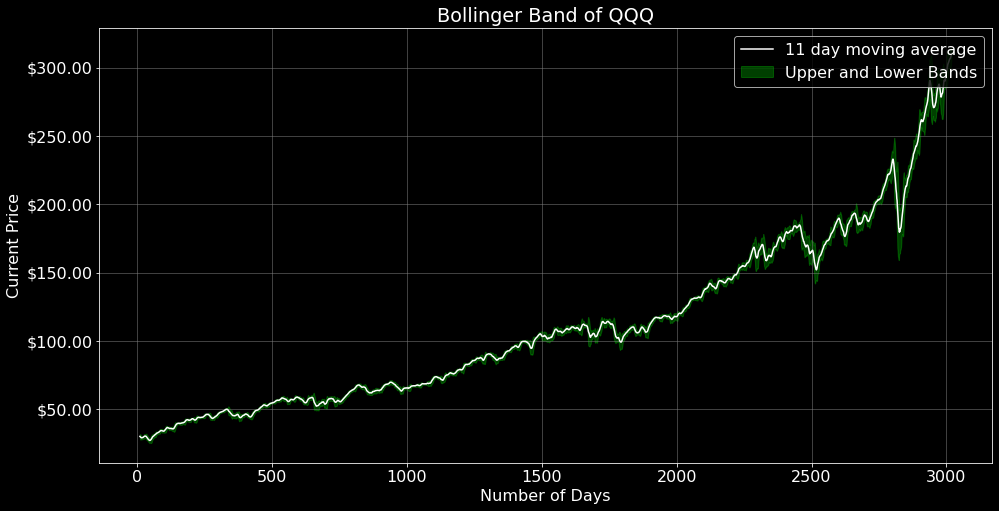

In [43]:
indicator_range = 26

for x in range(1, indicator_range+1):
    calculate_macd(df, x)
for x in range(6, indicator_range+1):
    calculate_rsi(df, x)
for x in range(1, indicator_range+1):
    calculate_sr(df, x)
for x in range(1, indicator_range+1):
    calculate_WR(df, x)
for x in range(1, indicator_range+1):
    calculate_ema(df, x)
for x in range(1, indicator_range+1):
    calculate_mfi(df, x)
for x in range(1, 2):
    calculate_bb(df, x)
for x in range(1, indicator_range+1):
    calculate_atr(df, x)
for x in range(1, indicator_range+1):
    calculate_kc(df, x)
for x in range(1, indicator_range+1):
    calculate_dema(df, x)
for x in range(1, indicator_range+1):
    calculate_cci(df, x)
for x in range(1, 7):
    calculate_emv(df, x)
for x in range(10, indicator_range+1):
    calculate_fi(df, x)
for x in range(5, indicator_range):
    calculate_roc(df, x)
for x in range(1, indicator_range+1):
    calculate_obv(df, x)

# Plot charts for a few Technical Indicators

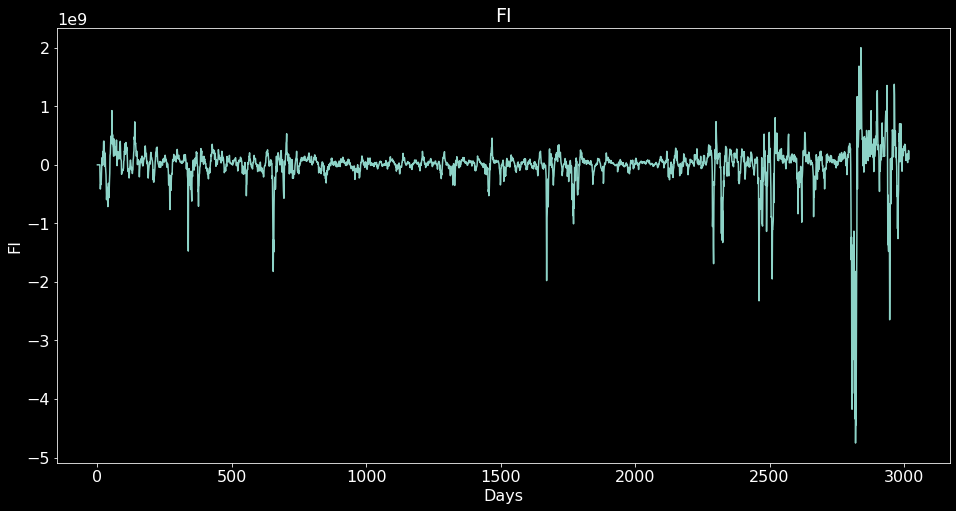

In [44]:
plot_indicators(df, "FI_10", "FI", "Days")

# Splitting dataframe into Test and Training dataframe

In [46]:
training_df = df[df['timestamps']<'2020-01-01'].copy()
test_df = df[df['timestamps']>='2020-01-01'].copy()

# Visualizing Prices from Training Dataframe

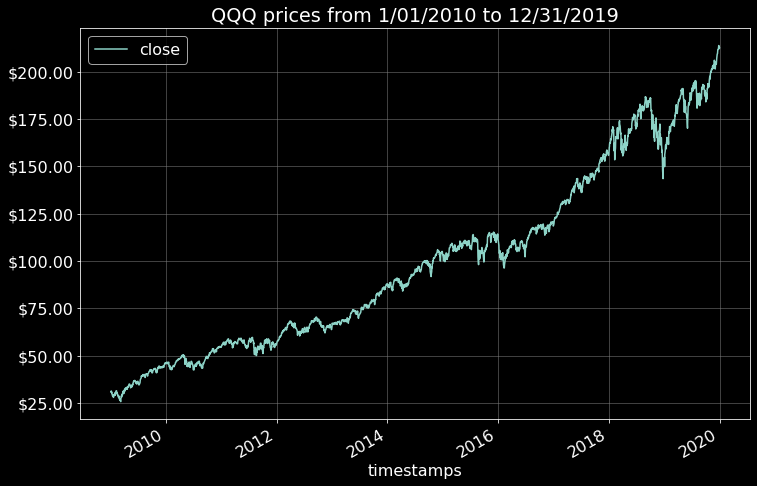

In [47]:
visualize_prices(training_df, 'timestamps', 'close', title=ticker + " prices from 1/01/2010 to 12/31/2019")

# Visualizing Prices from Testing Dataframe

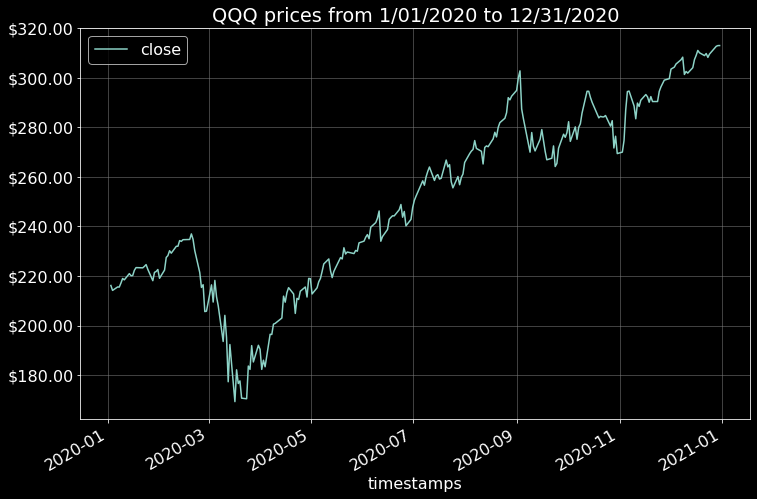

In [48]:
visualize_prices(test_df, 'timestamps', 'close', title=ticker + " prices from 1/01/2020 to 12/31/2020")

# Normalization and Splitting of Data

In [49]:
from sklearn.preprocessing import MinMaxScaler#, OneHotEncoder
from sklearn.model_selection import train_test_split
#from collections import Counter

pd.options.display.max_columns = 20

list_features = list(df.loc[:, ~df.columns.isin(['timestamps', 'labels'])].columns)
print('Total number of features', len(list_features))
#print("Columns:", list_features)




#x_test = test_df.loc[:, 'open': 'OBV_'+str(indicator_range)].values
x_test = test_df.loc[:, ~test_df.columns.isin(['timestamps', 'labels'])].values
y_test = test_df['labels'].values

# x_train, x_cv, y_train, y_cv = train_test_split(training_df.loc[:, 'open': 'OBV_'+str(indicator_range)].values, 
#                                                 training_df['labels'].values, 
#                                                 train_size=0.8, 
#                                                 test_size=0.2, 
#                                                 random_state=2, 
#                                                 shuffle=True, 
#                                                 stratify=training_df['labels'].values)

x_train, x_cv, y_train, y_cv = train_test_split(training_df.loc[:, ~training_df.columns.isin(['timestamps', 'labels'])].values, 
                                                training_df['labels'].values, 
                                                train_size=0.8, 
                                                test_size=0.2, 
                                                random_state=2, 
                                                shuffle=True, 
                                                stratify=training_df['labels'].values)



# Normalize the data in the range of [0, 1]
mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

print("Shape of x_train: {}, \tx_test: {}, \tx_cv: {}".format(x_train.shape, x_test.shape, x_cv.shape))
print("Shape of y_train: {}, \ty_test: {}, \ty_cv: {}".format(y_train.shape, y_test.shape, y_cv.shape))


# # df.loc[:, 'MACD':'RSI'].values: -> Data used to create 'x_train' and 'x_test'
# # df['labels'].values: -> Data used to create 'y_train' and 'y_test'
# #print(df.loc[:, 'MACD':'OBV'])
# x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'open': 'OBV_'+str(indicator_range)].values, df['labels'].values, train_size=0.8, test_size=0.2, random_state=2, shuffle=True, stratify=df['labels'].values)

# if 0.7*x_train.shape[0] < 2500:
#     # If training dataset is small, it increases the percentage of training
#     train_split = 0.8
# else:
#     train_split = 0.7

# print('train_split =', train_split)
# x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split, 
#                                                 random_state=2, shuffle=True, stratify=y_train)

# # Normalize the data in the range of [0, 1]
# mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
# x_train = mm_scaler.fit_transform(x_train)
# x_cv = mm_scaler.transform(x_cv)
# x_test = mm_scaler.transform(x_test)

# print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))

Total number of features 333
Shape of x_train: (2214, 333), 	x_test: (252, 333), 	x_cv: (554, 333)
Shape of y_train: (2214,), 	y_test: (252,), 	y_cv: (554,)


In [ ]:
# from sklearn.model_selection import train_test_split
# list_features = list(df.loc[:, 'open': 'KST_'+str(indicator_range)].columns) # Gets the names of all the columns from MACD to RSI
# print('Total number of features', len(list_features))
# print("Columns:", list_features)

# x_train_data, x_test_data, y_train_data, y_test_data = train_test_split(df.loc[:, 'MACD_6': 'KST_'+str(indicator_range)].values, df['open'].values, train_size=0.8, test_size=0.2, random_state=1, shuffle=True)

# Feature Selection

In [50]:
from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

num_features = 225  # should be a perfect square
selection_method = 'anova'
topk = 320 if selection_method == 'all' else num_features

if selection_method == 'anova' or selection_method == 'all':
    # Select features according to the k highest scores using f_classif
    select_k_best = SelectKBest(f_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_train, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_train, y_train)
    
    selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(selected_features_anova)
    print(select_k_best.get_support(indices=True))
    print("****************************************")

if selection_method == 'mutual_info' or selection_method == 'all':
  # Select features according to the k highest scores using mutual_info_classif
    select_k_best = SelectKBest(mutual_info_classif, k=topk)
    if selection_method != 'all':
        x_train = select_k_best.fit_transform(x_train, y_train)
        x_cv = select_k_best.transform(x_cv)
        x_test = select_k_best.transform(x_test)
    else:
        select_k_best.fit(x_train, y_train)

    selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
    print(len(selected_features_mic), selected_features_mic)
    print(select_k_best.get_support(indices=True))

if selection_method == 'all':
    # Chooses common features between anova and mutual_info if selection_method is set to 'all'
    common = list(set(selected_features_anova).intersection(selected_features_mic))
    print("common selected featues", len(common), common)
    if len(common) < num_features:
        raise Exception('number of common features found {} < {} required features. Increase "topk variable"'.format(len(common), num_features))
    feat_idx = []
    for c in common:
        feat_idx.append(list_features.index(c))
    feat_idx = sorted(feat_idx[0:225])
    print(feat_idx)  # x_train[:, feat_idx] will give you training data with desired features

('volume', 'diff', 'change', 'MACD_1', 'MACD_2', 'MACD_3', 'MACD_4', 'MACD_5', 'MACD_6', 'MACD_7', 'MACD_8', 'MACD_9', 'MACD_10', 'MACD_11', 'MACD_12', 'MACD_13', 'MACD_14', 'MACD_15', 'MACD_16', 'MACD_17', 'MACD_18', 'MACD_19', 'MACD_20', 'MACD_21', 'MACD_22', 'MACD_23', 'MACD_24', 'MACD_25', 'MACD_26', 'RSI_6', 'RSI_7', 'RSI_8', 'RSI_9', 'RSI_10', 'RSI_11', 'RSI_12', 'RSI_13', 'RSI_14', 'RSI_15', 'RSI_16', 'RSI_17', 'RSI_18', 'RSI_19', 'RSI_20', 'RSI_21', 'RSI_22', 'RSI_23', 'RSI_24', 'RSI_25', 'RSI_26', '%D_1', '%D_2', '%D_3', '%D_4', '%D_5', '%D_6', '%D_7', '%D_8', '%D_9', '%D_10', '%D_11', '%D_12', '%D_13', '%D_14', '%D_15', '%D_16', '%D_17', '%D_18', '%D_19', '%D_20', '%D_21', '%D_22', '%D_23', '%D_24', '%D_25', '%D_26', 'WR_1', 'WR_2', 'WR_3', 'WR_4', 'WR_5', 'WR_6', 'WR_7', 'WR_8', 'WR_9', 'WR_10', 'WR_11', 'WR_12', 'WR_13', 'WR_14', 'WR_15', 'WR_16', 'WR_17', 'WR_18', 'WR_19', 'WR_20', 'WR_21', 'WR_22', 'WR_23', 'WR_24', 'WR_25', 'WR_26', 'MFI_1', 'MFI_2', 'MFI_3', 'MFI_4', 'M

# Method: *reshape_as_image*

In [51]:
def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

# Reshaping the Data of 225 technical indicators into images

In [52]:
dim = int(np.sqrt(num_features)) # Computing dimension of image --> 15
x_train = reshape_as_image(x_train, dim, dim) # Reshape x_train into 15x15 image
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)
# adding a 1-dim for channels (3)
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)
# # Reshape y_train to N x 1
# y_train = y_train.reshape((len(y_train), 1))
# # Reshape y_test to N x 1
# y_test = y_test.reshape((len(y_test), 1))
# # Reshape y_test to N x 1
# y_cv = y_cv.reshape((len(y_cv), 1))
print("final shape of x_train: {}, y_train: \t{}".format(x_train.shape, y_train.shape))
print("final shape of x_test: \t{}, y_test: \t{}".format(x_test.shape, y_test.shape))
print("final shape of x_cv: \t{}, y_cv: \t{}".format(x_cv.shape, y_cv.shape))

final shape of x_train: (2214, 15, 15, 3), y_train: 	(2214,)
final shape of x_test: 	(252, 15, 15, 3), y_test: 	(252,)
final shape of x_cv: 	(554, 15, 15, 3), y_cv: 	(554,)


# Displays 9 random images within *x_train*

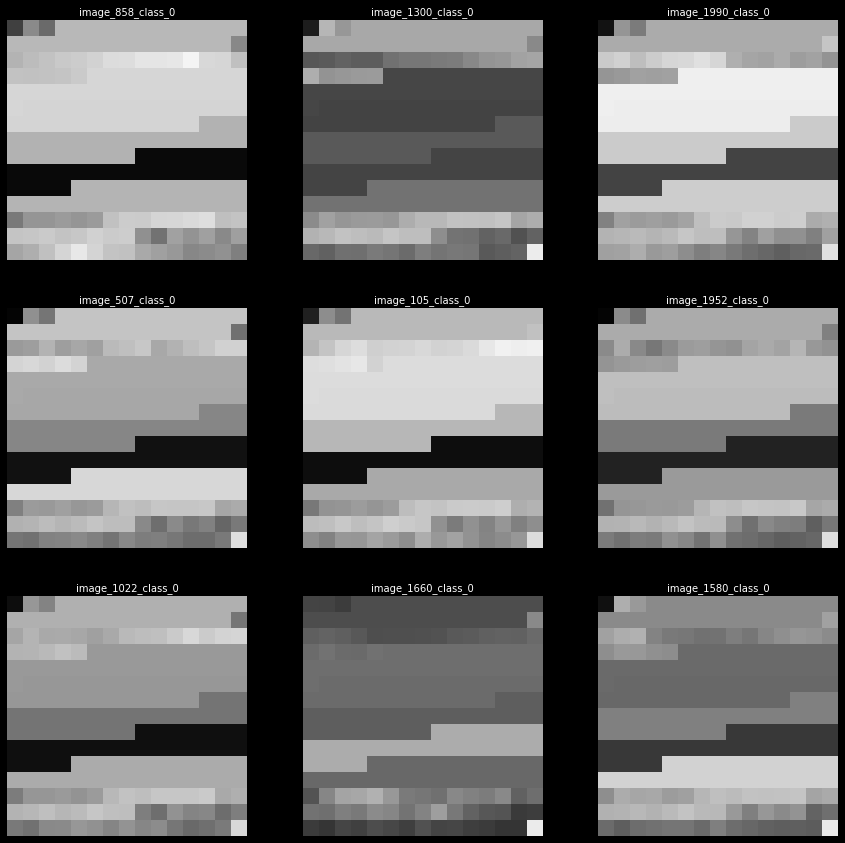

In [53]:
fig = plt.figure(figsize=(15, 15))
columns = rows = 3
for i in range(1, columns*rows +1):
    index = np.random.randint(len(x_train))
    img = x_train[index]
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('image_'+str(index)+'_class_'+str(np.argmax(y_train[index])), fontsize=10)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.imshow(img)
plt.show()

# Current Class Imbalance

Sell = 0, Buy = 1, Hold = 2

In [54]:
class_labels, class_count = np.unique(y_train, return_counts=True)
print("percentage of class 0 = {:.3f}%, class 1 = {:.3f}%, class 2 = {:.3f}%".format(class_count[0]/len(y_train)*100, class_count[1]/len(y_train)*100, class_count[2]/len(y_train)*100))

percentage of class 0 = 5.781%, class 1 = 5.872%, class 2 = 88.347%


# Examination of *x_train* shape

In [55]:
print(x_train[0].shape[0])
print(x_train[0].shape[1])
print(x_train[0].shape[2])
print(x_train.shape)

15
15
3
(2214, 15, 15, 3)


# Creating Testing Data

In [ ]:
#testing_data = df[df['timestamps']>='2020-01-01'].copy()
#visualize_prices(testing_data, 'timestamps', 'open')

#testing_data = testing_data.drop(['timestamps'], axis=1)
#testing_data = testing_data.iloc[1:]    # Drops first row in dataframe
#testing_data.head() 

# Using z-score standardization

In [ ]:
# from scipy import stats

# training_data = stats.zscore(training_data, axis=0, ddof=0, nan_policy='omit')

# n_bins = 50

# fig, axs = plt.subplots(2, 4, sharey=True, tight_layout=True)
# axs[0][0].hist(training_data[:, 0], bins=n_bins)
# axs[0][1].hist(training_data[:, 1], bins=n_bins)
# axs[0][2].hist(training_data[:, 2], bins=n_bins)
# axs[0][3].hist(training_data[:, 3], bins=n_bins)
# axs[1][0].hist(training_data[:, 4], bins=n_bins)
# axs[1][1].hist(training_data[:, 5], bins=n_bins)
# axs[1][2].hist(training_data[:, 6], bins=n_bins)

# Creating *x_train* and *y_train* data with time_step = 10

In [56]:
time_step = 10

temp_x_train = []
temp_y_train = []

for i in range(time_step, x_train.shape[0]):
    temp_x_train.append(x_train[i-time_step:i])
    temp_y_train.append(y_train[i])

# Creating *x_test* data with same time_step as *x_train*

In [57]:
print(x_test.shape)
print(x_train[-10:].shape)

x_train_offset = x_train[-10:]

x_test_with_x_train_offset = np.concatenate((x_train_offset, x_test))

print(x_test_with_x_train_offset.shape)

temp_x_test = []

for i in range(0, x_test.shape[0]):
    temp_x_test.append(x_test_with_x_train_offset[i:i+time_step])


(252, 15, 15, 3)
(10, 15, 15, 3)
(262, 15, 15, 3)


# Converting *x_train* and *y_train* to Numpy array and examining their shape

In [58]:
x_train, y_train = np.array(temp_x_train), np.array(temp_y_train)
x_train.shape, y_train.shape

((2204, 10, 15, 15, 3), (2204,))

In [59]:
x_test, y_test = np.array(temp_x_test), np.array(y_test)
x_test.shape, y_test.shape

((252, 10, 15, 15, 3), (252,))

In [ ]:
# print(y_train_data)

# time_step = 10

# x_train = []
# y_train= []

# for i in range(time_step,x_train_data.shape[0]):
#     x_train.append(x_train_data[i-time_step:i])
  

# for i in range(time_step,y_train_data.shape[0]):
#     y_train.append(y_train_data[i])

# print(len(y_train))

In [60]:
print(x_train.shape[1])
print(x_train.shape[2])
print(x_train.shape[3])
print(x_train.shape[4])

10
15
15
3


# Import needed Keras components

In [61]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPool2D, Activation, Flatten, InputLayer, TimeDistributed

# Build CNN-LSTM model

In [62]:
filters = 32

model = Sequential()

input_layer = InputLayer(input_shape=(10, x_train.shape[2], x_train.shape[3], x_train.shape[4]))
model.add(input_layer)
print(model.output_shape)

conv_2d_layer = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='glorot_uniform')
model.add(TimeDistributed(conv_2d_layer))
print(model.output_shape)

conv_2d_layer_2 = Conv2D(filters=filters*2, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='glorot_uniform')
model.add(TimeDistributed(conv_2d_layer_2))
print(model.output_shape)

max_2D_pooling = MaxPool2D(pool_size=2, padding='same')
model.add(TimeDistributed(max_2D_pooling))
print(model.output_shape)

relu_layer = Activation('relu')
model.add(relu_layer)
print(model.output_shape)

model.add(TimeDistributed(Flatten()))
print(model.output_shape)

model.add(LSTM(units=64, activation='relu'))
print(model.output_shape)

model.add(Dense(units=3, activation='softmax'))
print(model.output_shape)

(None, 10, 15, 15, 3)
(None, 10, 15, 15, 32)
(None, 10, 8, 8, 64)
(None, 10, 4, 4, 64)
(None, 10, 4, 4, 64)
(None, 10, 1024)
(None, 64)
(None, 3)


# Show summary of model

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 15, 15, 32)    896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 8, 8, 64)      18496     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 4, 4, 64)      0         
_________________________________________________________________
activation (Activation)      (None, 10, 4, 4, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 1024)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                278784    
_________________________________________________________________
dense (Dense)                (None, 3)                 1

# Compiling model

In [64]:
from tensorflow.keras import optimizers

learning_rate = 0.001

optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

#model.compile(optimizer=optimizer, loss='mean_absolute_error')
model.compile(optimizer=optimizer, loss='SparseCategoricalCrossentropy')

# Fitting model

In [65]:
model.fit(x_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
35/35 [==============================] - 17s 20ms/step - loss: 0.5538
Epoch 2/100
35/35 [==============================] - 1s 19ms/step - loss: 0.4359
Epoch 3/100
35/35 [==============================] - 1s 19ms/step - loss: 0.4770
Epoch 4/100
35/35 [==============================] - 1s 20ms/step - loss: 0.4414
Epoch 5/100
35/35 [==============================] - 1s 19ms/step - loss: 0.4273
Epoch 6/100
35/35 [==============================] - 1s 19ms/step - loss: 0.4770
Epoch 7/100
35/35 [==============================] - 1s 20ms/step - loss: 0.4100
Epoch 8/100
35/35 [==============================] - 1s 18ms/step - loss: 0.4271
Epoch 9/100
35/35 [==============================] - 1s 19ms/step - loss: 0.4506
Epoch 10/100
35/35 [==============================] - 1s 18ms/step - loss: 0.4553
Epoch 11/100
35/35 [==============================] - 1s 19ms/step - loss: 0.4531
Epoch 12/100
35/35 [==============================] - 1s 18ms/step - loss: 0.4542
Epoch 13/100
35/35 [====

# Creating BUY/SELL/HOLD prediction array

In [66]:
y_pred = model.predict(x_test)
y_pred.shape

(252, 3)

# Implementation of trading algorithm

In [67]:
model_variation = []
price_variation = []
share_hist = []
cash_hist = []

maximum_trade_size = 3000.00
cash_on_hand = 10000.00
initial_value = cash_on_hand
number_of_shares = 0.00
accuracy = 0

for i, pred_arr in enumerate(y_pred):
    max_index = np.argmax(pred_arr)
    current_price = df.iloc[-y_pred.shape[0]-1+i]['close']
    previous_price = df.iloc[-y_pred.shape[0]-2+i]['close']
    if (max_index == 0):
        # Determining how many share to sell
        shares_to_sell = min(round((maximum_trade_size * pred_arr[max_index]) / previous_price, 4), number_of_shares)
        # Prevent number of shares from dropping below 10
        if ((number_of_shares - shares_to_sell) < 10):
            shares_to_sell = 0
        number_of_shares = number_of_shares - shares_to_sell
        cash_on_hand = cash_on_hand + (shares_to_sell * previous_price)
    elif (max_index == 1):
        # Determining how many share to buy
        maximum_allow_trade_size = min(maximum_trade_size, cash_on_hand)
        shares_to_buy = round((maximum_allow_trade_size * pred_arr[max_index]) / previous_price, 4)
        shares_to_buy = max(shares_to_buy, 0)
        number_of_shares = number_of_shares + shares_to_buy
        cash_on_hand = cash_on_hand - (shares_to_buy * previous_price)
    # else:
    #     print("Hold")
    #print(5.00 * pred_arr[max_index])

    starting_price = df.iloc[-y_pred.shape[0]-1]['close']
    #print('starting_price:', starting_price)
    #print(df.iloc[-y_pred.shape[0]-1]['close'])

    price_variation.append((current_price-starting_price) / starting_price * 100)

    model_variation.append((cash_on_hand + (number_of_shares * current_price) - initial_value) / initial_value * 100)

    share_hist.append(number_of_shares)

    cash_hist.append(cash_on_hand)

    actual_label = df.iloc[len(df.index)-y_pred.shape[0]-1+i]['labels']

    if (max_index == actual_label):
        accuracy = accuracy + 1

end_price = df.iloc[len(df.index)-1]['close']
share_value = end_price * number_of_shares

model_variation = np.array(model_variation)   # Transformed into a numpy array
price_variation = np.array(price_variation)   # Transformed into a numpy array

print("Model accuracy: {:.3f}%".format(accuracy / (y_pred.shape[0]) * 100))

print("Cash left on hand: {:.3f}\nNumber of shares: {:.3f}\nValue of shares: {:.3f}\nTotal Value: {:.3f}".format(cash_on_hand, number_of_shares, share_value, cash_on_hand + share_value))

Model accuracy: 78.571%
Cash left on hand: 7984.442
Number of shares: 12.190
Value of shares: 3814.979
Total Value: 11799.421


# Create a Dataframe that contains the performance metrics of the model

In [68]:
p_df = pd.DataFrame()
p_df['timestamps'] = test_df['timestamps'].values
p_df['model_var'] = model_variation
p_df['price_var'] = price_variation
p_df['stock_hist'] = share_hist
p_df['cash_hist'] = cash_hist

# Visualizing Model Performance vs. Stock Price Change

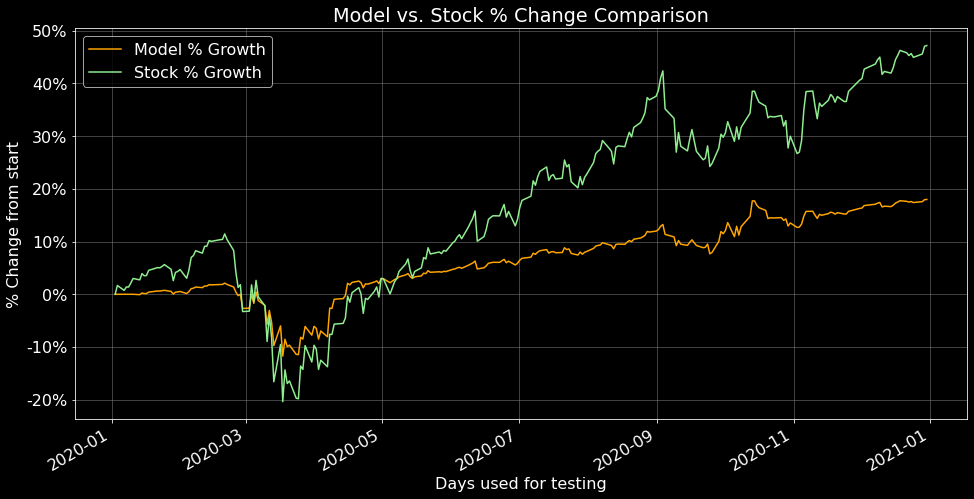

In [69]:
def visualize_performance():

    ax = p_df.plot(x='timestamps', y=['model_var', 'price_var'], color=['orange', 'lightgreen'])

    vals = ax.get_yticks()
    ax.set_yticklabels(['{:1.0f}%'.format(x) for x in vals])
    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    ax.legend(['Model % Growth', 'Stock % Growth'])
    ax.set_ylabel('% Change from start')
    ax.set_xlabel('Days used for testing')
    ax.set_title('Model vs. Stock % Change Comparison')

visualize_performance()

# import matplotlib.ticker as mtick

# fig, (ax) = plt.subplots(1, 1, sharex=True)

# fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
# yticks = mtick.FormatStrFormatter(fmt)
# ax.yaxis.set_major_formatter(yticks)

# ax.plot(price_variation, label='Stock % Growth')
# ax.plot(model_variation, label='Model % Growth')

# ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
# ax.set_axisbelow(True)
# ax.grid(linestyle='-', linewidth='0.5', color='gray')

# ax.legend(loc='upper left')

# ax.set_ylabel('% Change from start')
# ax.set_xlabel('Number of Days')
# ax.set_title('Model vs. Stock % Change Comparison')

# Method for ploting confusion matrix of Predicted and Actual labels

In [70]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

# Plots confusion matrix of Actual and Predicted Buy/Sell/Hold labels

Predicted   0  1    2  All
Actual                    
0.0         4  0   19   23
1.0         1  1   10   12
2.0        18  6  193  217
All        23  7  222  252


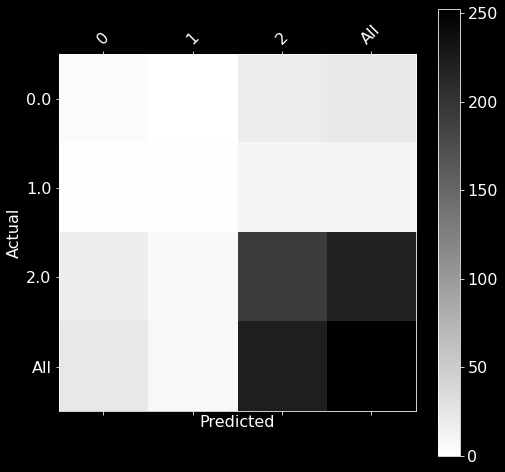

In [71]:
from sklearn.metrics import confusion_matrix
# Gets the index of each row with the highest prediction
pred_labels = np.argmax(y_pred, axis=1)
pred_labels = pd.Series(pred_labels, name='Predicted')
# Gets the actual label of the test data
actual_labels = df.iloc[-y_pred.shape[0]-1: -1]['labels'].to_numpy()
actual_labels = pd.Series(actual_labels, name='Actual')

df_confusion = pd.crosstab(actual_labels, pred_labels, rownames=['Actual'], colnames=['Predicted'], margins=True)
print(df_confusion)
plot_confusion_matrix(df_confusion)

# Method for visualizing marker placement on price and model value variation

<font color='red'>Remember:</font>  *SELL = 0, BUY = 1, HOLD = 2*


In [72]:
import matplotlib.ticker as mtick

def marker_visualization(actual_markers, predicted_markers):
    fig, (ax) = plt.subplots(1, 1, sharex=True)

    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)

    ax.plot(price_variation, 
            label='Stock % Growth', 
            color='lightgreen',
            markevery=actual_markers, 
            marker='o', 
            markerfacecolor='white', 
            markeredgecolor='blue', 
            markersize=7.5)
    ax.plot(model_variation, 
            label='Model % Growth', 
            color='orange',
            markevery=predicted_markers, 
            marker='^', 
            markerfacecolor='white',
            markeredgecolor='red', 
            markersize=7.5)

    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
    ax.set_axisbelow(True)
    ax.grid(linestyle='-', linewidth='0.5', color='gray')

    ax.legend(loc='upper left')

    ax.set_ylabel('% Change from start')
    ax.set_xlabel('Number of Days')
    ax.set_title('Model vs. Stock % Change Comparison')

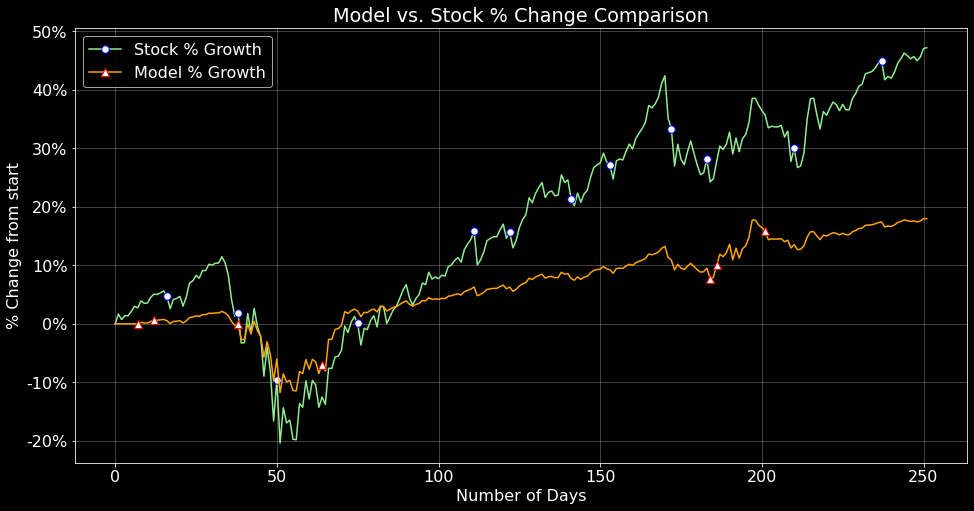

In [73]:
predicted_buy_markers = np.where(pred_labels == 1)
predicted_buy_markers = list(np.array(predicted_buy_markers)[0])
actual_buy_markers = list(np.where(df[-pred_labels.shape[0]:]['labels'] == 1)[0])

marker_visualization(actual_markers=actual_buy_markers, predicted_markers=predicted_buy_markers)

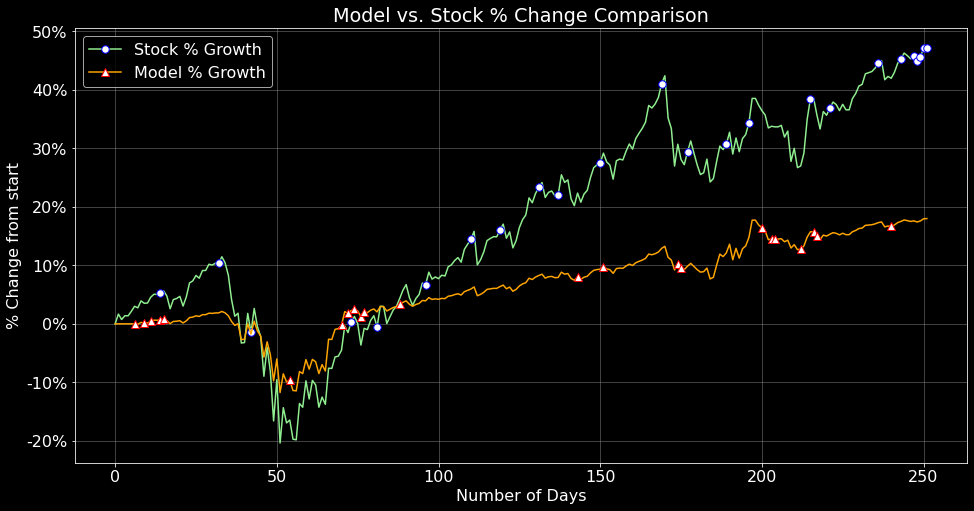

In [74]:
predicted_sell_markers = np.where(pred_labels == 0)
predicted_sell_markers = list(np.array(predicted_sell_markers)[0])
actual_sell_markers = list(np.where(df[-pred_labels.shape[0]:]['labels'] == 0)[0])


marker_visualization(actual_markers=actual_sell_markers, predicted_markers=predicted_sell_markers)
#marker_visualization(markers=predicted_sell_markers)

# Visualizing the number of shares over the course of the trading cycle

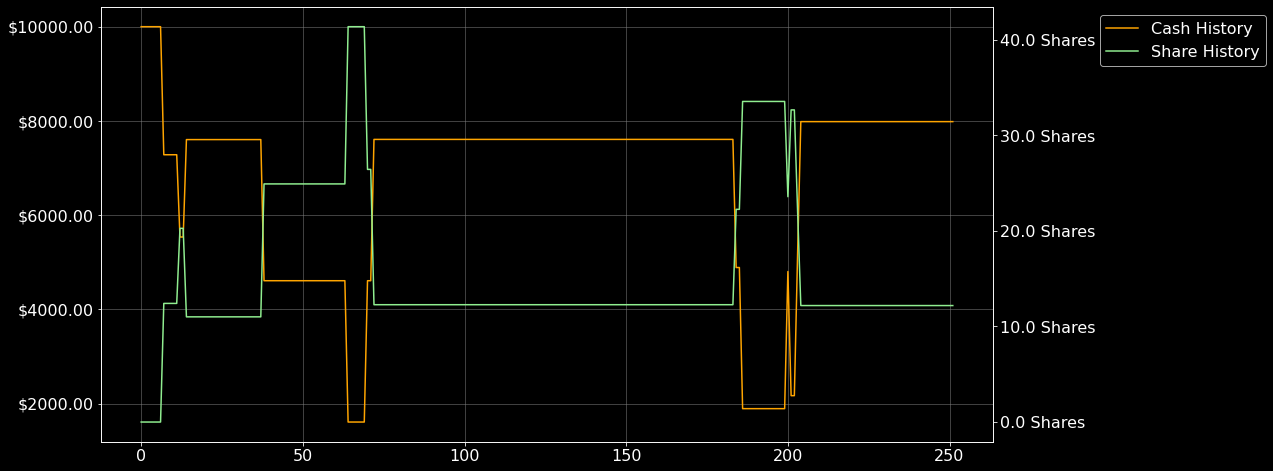

In [75]:
fig, (ax) = plt.subplots(1, 1, sharex=True)

# fmt = '%.0f%% Shares' # Format you want the ticks, e.g. '40%'
# yticks = mtick.FormatStrFormatter(fmt)
# ax.yaxis.set_major_formatter(yticks)

line_1 = ax.plot(cash_hist, color='orange', label='Cash History')
vals = ax.get_yticks()
ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

ax2 = ax.twinx()      # Add a secondary axis
line_2 = ax2.plot(share_hist, color='lightgreen', label='Share History')
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:1.1f} Shares'.format(x) for x in vals])

lns = line_1 + line_2
labs = [l.get_label() for l in lns]

ax.legend(lns, labs, bbox_to_anchor=(1.11, 1), loc='upper left')